# Modeling

In this tutorial, we will show you how to use `zephyr_ml`'s `Zephyr` class to train models. This tutorial builds on top of the previous one where we create EntitySets, generate label times, and do automated feature engineering. To do any of these previous steps, please refer to `feature_engineering` notebook.

## 1) Load the Feature Matrix

Load the feature matrix which is the result of the `feature_engineering` notebook. For the purpose of this tutorial, we use a dummy feature matrix stored in the `data/` folder.

In [1]:
import pandas as pd

feature_matrix = pd.read_csv('data/feature_matrix.csv')
feature_matrix

,COUNT(alarms),MAX(alarms.IND_DURATION),MIN(alarms.IND_DURATION),SUM(alarms.IND_DURATION),COUNT(stoppages),MAX(stoppages.COD_WO),MAX(stoppages.IND_DURATION),MAX(stoppages.IND_LOST_GEN),MIN(stoppages.COD_WO),MIN(stoppages.IND_DURATION),...,DES_CORE_ELEMENT_T12,DES_CORE_ELEMENT_T13,DES_CORE_ELEMENT_T14,DES_CORE_ELEMENT_T15,SITE_LOCATION,DES_CORE_PLANT_LOC,COD_PLANT_SAP_ABC,COD_PLANT_SAP_XYZ,PI_COLLECTOR_SITE_NAME_LOC0,PI_LOCAL_SITE_NAME_LOC0
0,1,NaN,NaN,0.0,1,12345.0,NaN,NaN,12345.0,NaN,...,0,0,0,0,1,1,1,0,1,1
1,0,NaN,NaN,0.0,1,37452.0,NaN,NaN,37452.0,NaN,...,0,0,0,0,1,1,1,0,1,1
2,0,NaN,NaN,0.0,1,23432.0,NaN,NaN,23432.0,NaN,...,0,0,0,0,1,1,1,0,1,1
3,0,NaN,NaN,0.0,1,12452.0,NaN,NaN,12452.0,NaN,...,0,0,0,0,1,1,1,0,1,1
4,0,NaN,NaN,0.0,1,32435.0,NaN,NaN,32435.0,NaN,...,0,0,0,0,1,1,1,0,1,1
5,0,NaN,NaN,0.0,1,23534.0,NaN,NaN,23534.0,NaN,...,0,0,0,0,1,1,1,0,1,1
6,0,NaN,NaN,0.0,1,65431.0,NaN,NaN,65431.0,NaN,...,0,0,0,0,1,1,1,0,1,1
7,0,NaN,NaN,0.0,1,35742.0,NaN,NaN,35742.0,NaN,...,0,0,0,0,1,1,0,1,1,1
8,0,NaN,NaN,0.0,1,21343.0,NaN,NaN,21343.0,NaN,...,0,0,0,0,1,1,0,1,1,1
9,0,NaN,NaN,0.0,1,43565.0,NaN,NaN,43565.0,NaN,...,0,0,0,0,1,1,0,1,1,1


## 2) Preparing Model Inputs

Prepare the data for modeling. Depending on the data, you might need to: normalize the data, impute missing values, etc.

In this part of the notebook, we do the following:
* create `X` and `y` variables from the feature matrix
* impute missing values using a SimpleImpute
* pass the data into our `Zephyr` instance and split the data into training and testing

In [2]:
from sklearn.impute import SimpleImputer
from zephyr_ml import Zephyr

# pop the target labels
y = list(feature_matrix.pop('label'))
print(y)
X = feature_matrix.values


# impute missing values
imputer = SimpleImputer()
X = pd.DataFrame(imputer.fit_transform(X))

zephyr = Zephyr()
zephyr.set_feature_matrix(X, labels = y)
X_train, X_test, y_train, y_test = zephyr.generate_train_test_split(test_size=0.2, random_state=33)

/Users/raymondpan/zephyr/Zephyr-repo/venv/lib/python3.8/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: [ 1  2  6  7  9 10 15 16 17 18]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
[GUIDE] Successfully performed set_feature_matrix.
	You can perform the next step by calling generate_train_test_split.
[GUIDE] Successfully performed generate_train_test_split.
	You can perform the next step by calling fit_pipeline.


[True, False, True, False, True, False, False, False, False, True, False, False, False]


## 3) Train a Model

We train a model using `Zephyr`'s `fit_pipeline` method.
In this notebook, we use an `xgb_classifier` pipeline which consists of two primitives:

```
        "xgboost.XGBClassifier"
        "zephyr_ml.primitives.postprocessing.FindThreshold"
```

An `XGBClassifier` primitive is an XGB model that returns the probability of each class, and `FindThreshold` primitive creates binary labels from the output of the XGB model by choosing a threshold that produces the best metric value (F1 Score by default)

To use a pipeline, we simply pass the name of the pipeline to our `Zephyr` instance.
Optionally, you can change the default settings of the primitive by passing a hyperparameter dictionary. For example, we can change the number of trees in the classifier to be 50 instead of the default value (100).

In [3]:
hyperparameters = {
    "xgboost.XGBClassifier#1": {
        "n_estimators": 50
    }
}

zephyr.fit_pipeline(pipeline = "xgb_classifier", pipeline_hyperparameters = hyperparameters)

Now that the pipeline is trained, we can use it to predict the values of the test data using `predict` function


In [4]:
zephyr.predict()

[1, 0, 1]

Lastly, we can evaluate the performance of the pipeline using `evaluate` function


In [5]:
res = zephyr.evaluate()

In [6]:
res

{'sklearn.metrics.accuracy_score': 0.6666666666666666,
 'sklearn.metrics.precision_score': 0.5,
 'sklearn.metrics.f1_score': 0.6666666666666666,
 'sklearn.metrics.recall_score': 1.0,
 'zephyr_ml.primitives.postprocessing.confusion_matrix': (array([[1, 1],
         [0, 1]]),
  <Figure size 640x480 with 2 Axes>),
 'zephyr_ml.primitives.postprocessing.roc_auc_score_and_curve': (0.5,
  <Figure size 640x480 with 1 Axes>)}

The `confusion_matrix` and `roc_auc_score_and_curve` evaluation metrics return some `matplotlib.figure.Figure` objects, which we can display, as shown below.

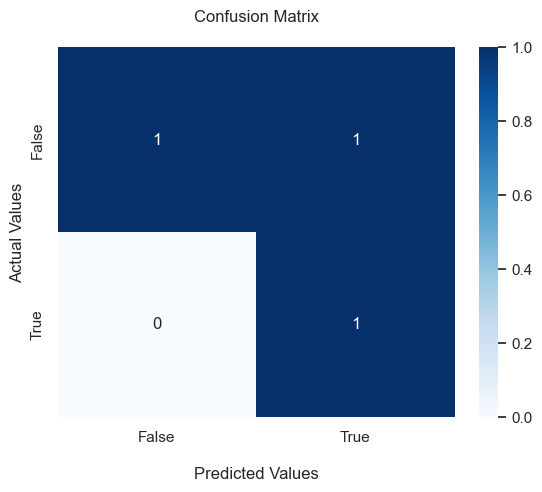

In [7]:
%matplotlib inline
_, conf_matrix_fig = res["zephyr_ml.primitives.postprocessing.confusion_matrix"]
conf_matrix_fig

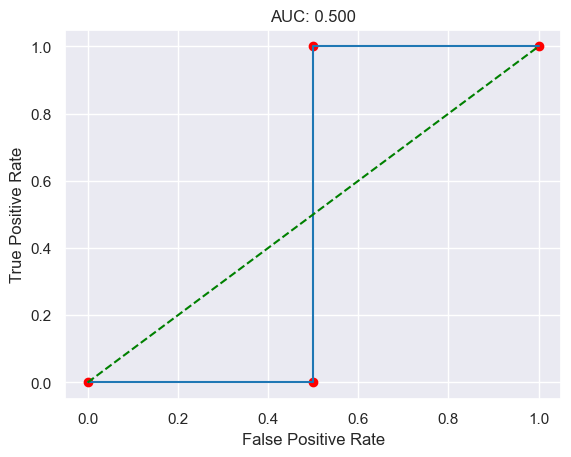

In [8]:

_, roc_fig = res["zephyr_ml.primitives.postprocessing.roc_auc_score_and_curve"]

roc_fig
